## 获取数据

In [1]:
import os
import pandas as pd
def load_housing_data(housing_path = './'):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [2]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

In [4]:
housing.info()  # 查看数据集的简单描述， 得到每个属性类型和非空值数据量

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#  total_bedrooms  20433 有一部分空值
housing['ocean_proximity'].value_counts()  # 查看多少种分类  ，5 种分类，获得每种分类下有少区域

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()  # 显示数值属性摘要

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


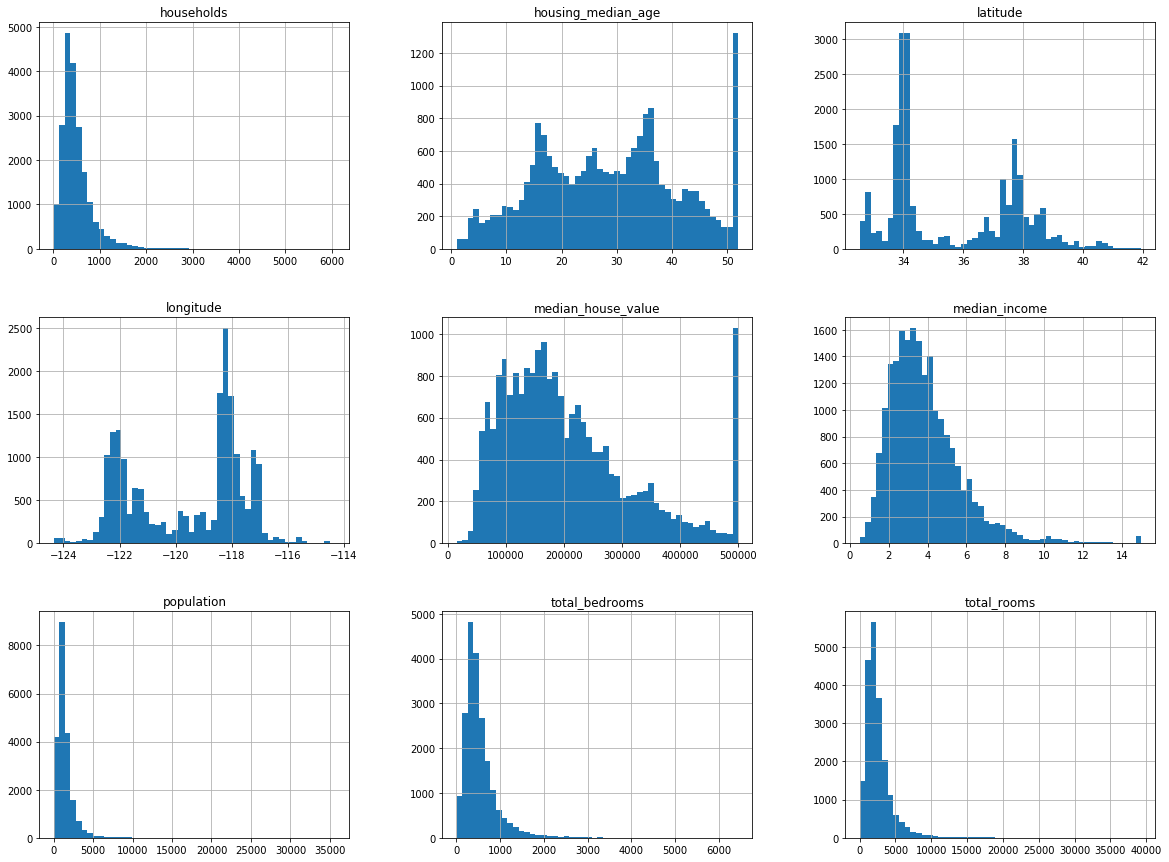

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()



### 房龄和房价被设定了上限
   1. 设置了上限的区域，重新收集标签值
   2. 把设置了上限的区域数据移除
   
### 重尾 头高尾长
   * 转换数据，把数据形状变成偏钟形分布（正太分布， 平均值为0，标准差为1）
### 收入特征
   * 数据提供的上游证实 是年薪 单位万美元， 提前对特征进行缩放是正常的，需要得知数据是如何缩放的

## 创建训练集和测试集
   * 训练集用于模型训练 占整个数据集的80% ，测试占20%

In [8]:
import numpy as np
def split_train_test(data, test_radio):
    np.random.seed(42)
    indices = np.random.permutation(len(data))  # 对原来的数组进行重新洗牌，随机打乱原来的元素顺序
    test_set_size = int(len(data) * test_radio)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return data.iloc[train_indices],  data.iloc[test_indices]

In [9]:
train_set, test_set =  split_train_test(housing, 0.2)

In [10]:
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
# 对样本设置唯一的标识符，对标识符取hash值， 去hash的最后一个字节， 值小于等于51 ，256*20%，放入测试集
# hash值相同，对象不一定相同，hash不同，对象一定不同 

import hashlib

def test_set_check(identifier, test_radio, hash = hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_radio  # 返回摘要，作为二进制数据字符串


In [13]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
housing_with_id = housing.reset_index()  # 使用行索引作为标识符 ID

In [16]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [18]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [19]:
# 基于行索引，不能删除和中间插入数据，只能末尾插入，否则行索引会变
# 寻找稳定特征来创建唯一标识符，

In [20]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

In [21]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [22]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [23]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [24]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [25]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


## 从数据可视化中探索数据

### 分层采样


In [26]:
# 抽样偏差：调查公司给1000个人来调研几个问题，不会在电话簿中随机查找1000人，他们视图确保1000人代表全体人口，美国人，51.3女性，48.7男性
# 你的调查应该维持这一比例，513名女性，487男性，这就是分层采样，人口划分为均匀的子集，每个子集称为一层，然后从每层中抽取正确的实例数量

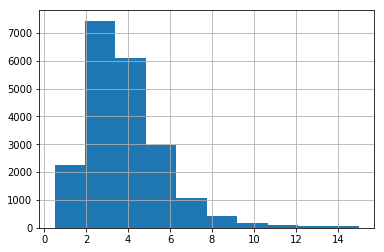

In [27]:
housing['median_income'].hist()

In [28]:
# 希望测试集能够代表整个数据集中各种不同类型的收入

   1. 创建一个收入类别属性 
   2. 不应该数据分层太多，但每一层应该有足够的数据量
   3. 将收入中位数处以1.5，限制收入类别数量，使用ceil取整，得到离散类别，将大于5的列别合并为类别5

In [29]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].head(20)

housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True )

In [30]:
housing['income_cat'].head(20)

0     5.0
1     5.0
2     5.0
3     4.0
4     3.0
5     3.0
6     3.0
7     3.0
8     2.0
9     3.0
10    3.0
11    3.0
12    3.0
13    2.0
14    2.0
15    2.0
16    2.0
17    2.0
18    2.0
19    2.0
Name: income_cat, dtype: float64

In [31]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1,2, 3, 4, 5]) # 把连续值转换成类别标签  

In [32]:
housing['income_cat'].head(20)

0     5
1     5
2     5
3     4
4     3
5     3
6     3
7     3
8     2
9     3
10    3
11    3
12    3
13    2
14    2
15    2
16    2
17    2
18    2
19    2
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [33]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

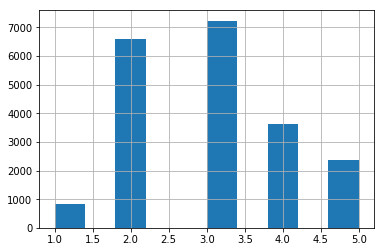

In [34]:
# 收入类别直方图
housing['income_cat'].hist()

In [35]:
# 根据收入类别进行分层采样
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state = 42 )

In [37]:
for  train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [38]:
strat_train_set.shape


(16512, 11)

In [39]:
strat_train_set.head(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,INLAND,3
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,500001.0,<1H OCEAN,5
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,INLAND,4
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,<1H OCEAN,2
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN,1


In [40]:
# 查看所有住房数据根据收入类别比例分布，收入占类别百分比
strat_test_set['income_cat'].value_counts()/len(strat_test_set)  # 分层抽样测试集合

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [41]:
housing['income_cat'].value_counts()/len(housing)  # 完整数据集合

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [42]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "全部数据": income_cat_proportions(housing),
    "分层抽样": income_cat_proportions(strat_test_set),
    "随机抽样": income_cat_proportions(test_set),
}).sort_index()
compare_props["随机. %error"] = 100 * compare_props["随机抽样"] / compare_props["全部数据"] - 100
compare_props["分层. %error"] = 100 * compare_props["分层抽样"] / compare_props["全部数据"] - 100

In [43]:
compare_props

,全部数据,分层抽样,随机抽样,随机. %error,分层. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [44]:
# 把测试集已经处理完成，用分层抽样的训练集数据来进行分析


## 将地理数据可视化

In [45]:
# 建立一个各区域的分布图，以便于数据可视化

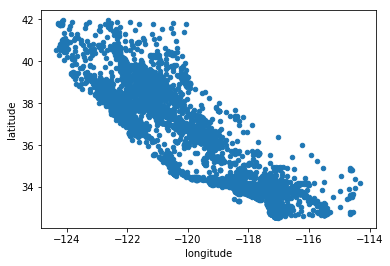

In [46]:
housing.plot(kind='scatter', x='longitude', y = 'latitude')

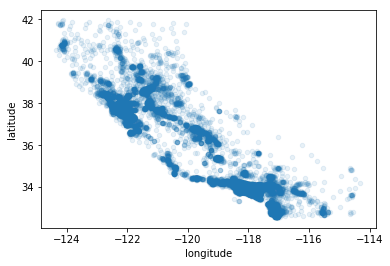

In [47]:
# 将alpha 设置为 0.1 ， 可以看出高密度数据点的位置
housing.plot(kind='scatter', x='longitude', y = 'latitude', alpha=0.1)

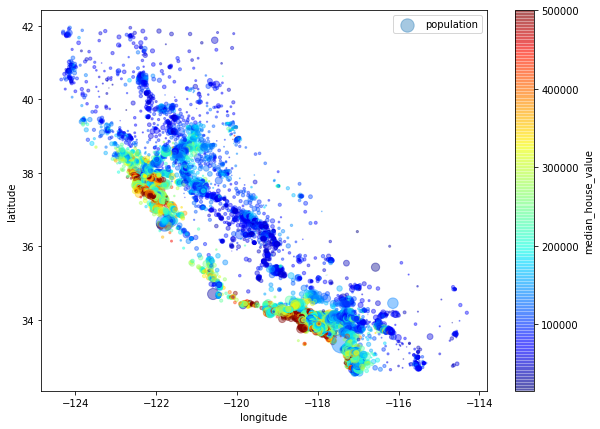

In [48]:
# 我们的大脑非常善于从图片中发现模式，但是需要玩转可视化参数才能让这些模式凸显出来
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

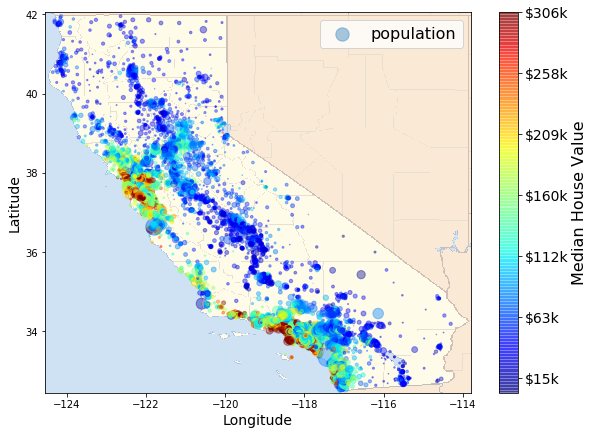

In [49]:
import matplotlib.image as mpimg
california_img = mpimg.imread('./california.png')

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False,
    sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)


prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()



In [50]:
# 从图片中告诉我们，房屋价格与地理位置靠海，和人口密度息息相关

## 寻找特征相关性

In [51]:
# corr() 计算出每对特征之间的相关系数， 称为皮尔逊相关系数
corr_matrix =  housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [52]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

   * 相关系数范围 从 -1 变化到 1，越接近1 ，表示越强的正相关，，比如，当收入中位数上升时，房价中位数也趋于上升，
   * 当系数接近-1 ，则表示有强烈的负相关，纬度和房价中位数之间出现轻微的负相关，越往北走，房价倾向于下降，
   * 系数靠近0 ，说明二者之间没有线性相关性，
   * 相关系数仅检测 线性相关性 ，如果x上升，y上升或者下降，可能会彻底遗漏非线性相关性，例如 如果x接近于0，y上升

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18742c50>,
      dtype=object)

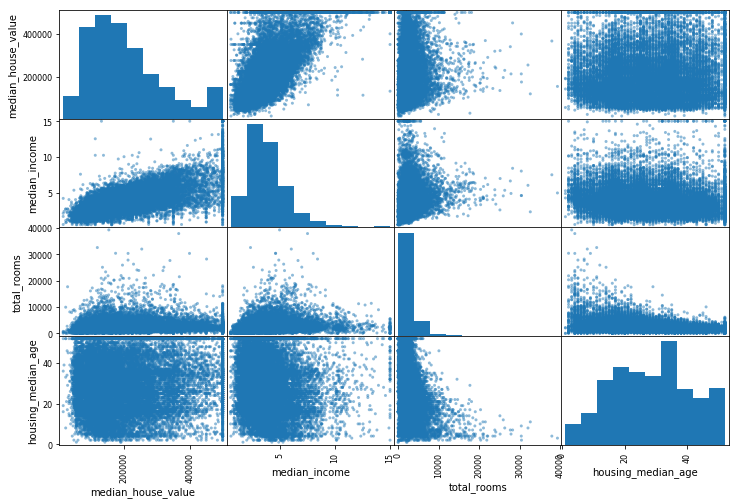

In [53]:
# 使用padans scatter_matrix 函数，可以绘制特征之间的相关性
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12, 8) )

[0, 16, 0, 550000]

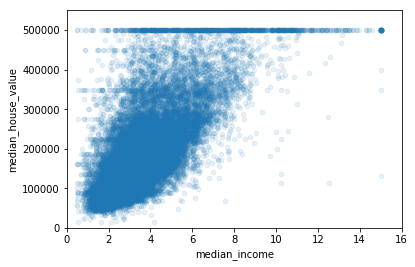

In [54]:
housing.plot(kind = 'scatter', x='median_income', y = 'median_house_value', alpha = 0.1)
plt.axis([0, 16, 0, 550000])

In [55]:
# 50万美元是一条清晰的线，被设置上限了， 45w，35w，28w，也有虚线， 可能是异常值，我可以在后期把数据删除掉

   1. 在给机器学习算法输入数据之前，我们识别出了一些异常数据，需要提前清理掉，也发现了不同属性之间的某些联系，跟目标属性相关的联系
   2. 某些属性分布显示出了明显的“重尾”分布，对进行转换处理，计算其对数
   3. 在给机器学习算法输入数据之前，最后一件事儿，尝试各种属性的组合
   4. 每个项目历程都不一样，大致思路都相识

## 试验不同特征的组合

In [56]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [57]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [58]:
# 关联矩阵
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## 机器学习算法的数据准备

In [59]:
# 得到一个分层抽样代表全局数据集的  训练集和测试集
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3


In [60]:
# 将数据集的数据和标签分开 
housing_labels = strat_train_set['median_house_value'].copy()

In [61]:
housing = strat_train_set.drop('median_house_value', axis = 1)

In [62]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3


In [63]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null category
dtypes: category(1), float64(8), object(1)
memory usage: 1.3+ MB


## 数据清洗

   * 大多数机器学算法无法在缺失的特征上工作，创建一些函数辅助，total_bedrooms有缺失，
   1. 放弃这些区域
   2. 放弃这个属性
   3. 将缺失值 设置为 某个值，（0， 平均数或者中位数都可以）

In [64]:
rows = housing[housing.isnull().any(axis = 1)]
rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3


In [65]:
# # 放弃这些区域
# rows.dropna(subset = ['total_bedrooms'])
# # 放弃这个属性
# rows.drop('total_bedrooms', axis = 1)
#  将缺失值 设置为 某个值，（0， 平均数或者中位数都可以）

# 创建一个imputer实例，指定你要用属性中的中位数值替换该属性的缺失值 
from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy = 'median')

# 使用fit() 方法将 imputer实例适配到训练集
housing_num = housing.drop('ocean_proximity', axis =1)

imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [120]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [66]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [67]:
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  339.    ,    2.7042,
           2.    ],
       [-121.93  ,   37.05  ,   14.    , ...,  113.    ,    6.4214,
           5.    ],
       [-117.2   ,   32.77  ,   31.    , ...,  462.    ,    2.8621,
           2.    ],
       ...,
       [-116.4   ,   34.09  ,    9.    , ...,  765.    ,    3.2723,
           3.    ],
       [-118.01  ,   33.82  ,   31.    , ...,  356.    ,    4.0625,
           3.    ],
       [-122.45  ,   37.77  ,   52.    , ...,  639.    ,    3.575 ,
           3.    ]])

In [68]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0


In [69]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
income_cat            16512 non-null float64
dtypes: float64(9)
memory usage: 1.3 MB


## scikit-Learn
* 一致性
   1. 估算器
       比如：各种机器学习算法
       fit()执行估算器

   2. 转换器  
       比如：LabelBinarizer
       transform()  执行转换数据集
       fit_transform()  先估算，再转换
   3. 预测器
       predict()  对给定的新数据集进行预测
       score()    评估测试集的预测质量
* 检查
    1. imputer.strategy_学习参数通过公共实例变量访问

## 处理文本和分类属性

In [70]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [71]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [72]:
# 将文本转化成对应的数字分类 ， 使用转换器
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoder = encoder.fit_transform(housing_cat)
housing_cat_encoder

array([0, 0, 4, ..., 1, 0, 3])

In [73]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

   1. 机器学习算法会以为两个相近的数字比远的数字更相似，比如0，4 比  0，1相似度更高，
   2. 创建独热编码，当 <1H ,第0个属性为1，其余都为0， 列别是InLand时候，另一个属性为1，其余为0，1为热，0为冷，独热编码
   3. OneHotEncoder编码器, fit_trans需要二维数组， 转换housing_cat

In [74]:

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [75]:
housing_cat_encoder

array([0, 0, 4, ..., 1, 0, 3])

In [76]:
housing_cat_encoder.reshape(-1, 1)

array([[0],
       [0],
       [4],
       ...,
       [1],
       [0],
       [3]])

In [77]:
housing_cat_hot = encoder.fit_transform(housing_cat_encoder.reshape(-1, 1))
housing_cat_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [78]:
# 从稀疏矩阵 转换成 numpy
housing_cat_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [79]:
# 一次完成两个转换 文本--整数类型--独热类型
housing_cat
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [80]:
# 输出稀疏矩阵

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output = True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## 自定义转换器

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin


rooms_ix, bedrooms_ix, population_ix, household_ix = [list(housing.columns).index(col) for col in ("total_rooms", "total_bedrooms", "population", "households")]
rooms_ix, bedrooms_ix, population_ix, household_ix 
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household,population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household,population_per_household]
        
        
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [82]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., 2, 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., 5, 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 2, 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 3, 6.34640522875817, 2.742483660130719],
       [-118.01, 33.82, 31.0, ..., 3, 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 3, 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [83]:
housing_tr = pd.DataFrame(housing_extra_attribs)
housing_tr.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


In [84]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


In [85]:
housing_extra_attribs.sample(20)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12347,-116.54,33.82,12,9482,2501,2725,1300,1.5595,INLAND,2,7.29385,2.09615
6263,-117.96,34.04,34,1381,265,1020,268,4.025,<1H OCEAN,3,5.15299,3.80597
12208,-117.1,33.56,6,1868,289,750,247,4.3833,<1H OCEAN,3,7.56275,3.03644
6396,-118.03,34.14,44,1446,250,721,243,4.7308,INLAND,4,5.95062,2.96708
12601,-121.48,38.53,37,1704,361,902,356,1.9837,INLAND,2,4.78652,2.53371
13354,-117.61,34.02,15,1791,346,1219,328,3.8125,INLAND,3,5.46037,3.71646
5749,-118.27,34.16,45,1865,360,973,349,3.6587,<1H OCEAN,3,5.34384,2.78797
18799,-121.89,40.97,26,1183,276,513,206,2.225,INLAND,2,5.74272,2.49029
15022,-117,32.77,30,1802,401,776,386,2.8125,<1H OCEAN,2,4.66839,2.01036
16834,-122.55,37.59,31,1331,245,598,225,4.1827,NEAR OCEAN,3,5.91556,2.65778


## 特征缩放

In [86]:
# 最重要也是最需要应用在数据上的转换器，就是特征缩放，输入数值属性有很大的比例差异，会导致机器学习算法性能表现不佳
# 房间总数 范围6到39320，收入中位数范围0到15
# 目标值通常不需要缩放
# 同比缩放所有属性，2种方法 最小-最大缩放和标准化
# 最小-最大缩放，又叫归一化，将值重新缩放到0到1之间，将值减去最小值并除以最大值和最小值差，如果你不希望是0到1，可以调整超参数feature_range
# 标准化 减去平均值 ，所以标准化均值总是0，然后除以方差，结果的分布具备单位方差，不同于归一化，标准化不将值绑定到特定范围，受异常值影响小
# 缩放器仅用来拟合训练集，不是完成的数据集


## 转换流水线

In [87]:
# 许多数据转换的步骤需要以正确的顺序来执行， PipeLine来支持这样的转换
# pipline构造函数会通过一系列名称/估算器的配对来定义步骤的序列，必须是转换器，必须有fit_fransform()方法
# 调用流水芡的fit方法时，会在所有转换器上按照顺序依次调用fit_transform()，将一个调用的输出作为参数传递给下一个调用方法，直到传递到最终
# 估算器，只会调用fit方法
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [88]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
income_cat            16512 non-null category
dtypes: category(1), float64(8)
memory usage: 1.1 MB


In [89]:
# dataFrame -> series -> ndarray
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [90]:
num_attribs =list(housing_num) 
num_attribs


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'income_cat']

In [91]:

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [92]:
from sklearn.base import TransformerMixin 
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [93]:
cat_attribs = ['ocean_proximity']
from sklearn.preprocessing import LabelBinarizer

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),               
        ('LabelBinarizer', MyLabelBinarizer()),
    ])

# housing.head()

In [94]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipline", num_pipeline,),
        ('cat_pipline', cat_pipeline),
    ])

In [95]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [96]:
housing_prepared = pd.DataFrame(housing_prepared)
housing_prepared.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.954456,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.890305,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.954456,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.954456,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.006202,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


## 选择和训练模型
* 获得了数据
* 数据探索
* 对训练集和测试集进行拆分
* 编写了转换数据流水线
* 自动清理和准备机器学习算法的数据

In [97]:
df = pd.DataFrame(housing_prepared)
df.head()
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
19480    127900.0
8879     500001.0
13685    140200.0
4937      95000.0
4861     500001.0
16365     92100.0
19684     61500.0
19234    313000.0
13956     89000.0
2390     123900.0
11176    197400.0
15614    500001.0
2953      63300.0
13209    107000.0
6569     184200.0
5825     280900.0
18086    500001.0
16718    171300.0
13600    116600.0
13989     60800.0
15168    121100.0
6747     270700.0
7398     109900.0
5562     159600.0
16121    500001.0
           ...   
12380    122500.0
5618     350000.0
10060    172800.0
18067    500001.0
4471     146600.0
19786     81300.0
9969     247600.0
14621    164100.0
579      254900.0
11682    185700.0
245      126800.0
12130    114200.0
16441    101800.0
11016    265600.0
19934     88900.0
1364     225000.0
1236     123500.0
5364     500001.0
11703    321600.0
10356    266000.0
15270    346700.0
3754     190200.0
12166    148800.0
6003     214800.0
7364     1

##  训练模型和评估训练集

In [98]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
# 预测数据
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]


In [100]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 大多数地区的房屋中位数 在120000到265000美元之间，预测误差高达 68628,这是一个典型的模型对训练数据拟合不足的案例，
# 原因可能是特征无法提供足够的信息来做出更好的预测，或者模型本身不够强大，
# 1. 选择强大的模型，2 为算法提供更好的特征，3.减少对模型的限制等方法，

# 决策树可以找到复杂的非线性关系


68376.64295459937

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [102]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [103]:
 # 完美，也可能是这个模型对数据严重过度拟合了，如何确认？轻易不要启动测试集，拿训练集中的一部分用于训练，另一部分用于模型的验证

## 使用交叉验证来更好的进行评估

In [104]:
# 使用train_test_split函数将训练集分为较小的训练集和验证集，然后根据这些较小的训练集来训练模型，并对其进行评估
# sklearn的交叉验证，将训练集随机分割成10个不同的子集，每个子集称为一个折叠，对模型进行10次训练和评估，每次挑选1个折叠进行评估，另外9个进行训练
from sklearn.model_selection import cross_val_score
# neg_mean_squared_error‘ 也就是 均方差回归损失 该统计参数是预测数据和原始数据对应点误差的平方和的均值

# 决策树交叉验证
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores


array([70307.54079165, 67270.94561829, 71361.89886493, 68889.91784739,
       70992.94150631, 74140.66907294, 70607.72083897, 70576.13836762,
       76433.16342183, 70270.96266671])

In [105]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70307.54079165 67270.94561829 71361.89886493 68889.91784739
 70992.94150631 74140.66907294 70607.72083897 70576.13836762
 76433.16342183 70270.96266671]
Mean: 71085.189899664
Standard deviation: 2431.961029690467


In [106]:
# 线性 交叉验证
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449328
Standard deviation: 2662.7615706103443


In [107]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [108]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22112.540875989125

In [109]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51513.5500248  48821.99364978 53451.63889205 54910.55855153
 50405.68166817 56772.90691171 51909.21824137 50516.14893695
 55699.80788403 53107.7805515 ]
Mean: 52710.92853118938
Standard deviation: 2414.7271791176026


## 模型调参和网格搜索
   1. 手动调整超参数，找到很好的组合很困难
   2. 使用GridSearchCV替你进行搜索，告诉它，进行试验的超参数是什么，和需要尝试的值，它会使用交叉验证评估所有超参数的可能组合

In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [112]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64265.85210091941 {'max_features': 2, 'n_estimators': 3}
55882.984840186626 {'max_features': 2, 'n_estimators': 10}
53472.52977048399 {'max_features': 2, 'n_estimators': 30}
61320.61721024631 {'max_features': 4, 'n_estimators': 3}
53834.66617027598 {'max_features': 4, 'n_estimators': 10}
51273.25987325864 {'max_features': 4, 'n_estimators': 30}
59851.160077252265 {'max_features': 6, 'n_estimators': 3}
53108.49267924178 {'max_features': 6, 'n_estimators': 10}
50804.490677496164 {'max_features': 6, 'n_estimators': 30}
59225.21977850634 {'max_features': 8, 'n_estimators': 3}
52883.78258097852 {'max_features': 8, 'n_estimators': 10}
50942.15913785863 {'max_features': 8, 'n_estimators': 30}
62801.35724701795 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54452.705621479254 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61122.949491813 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53014.33296453683 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [114]:
# 数据准备步骤也可以当作超参数来处理，网格搜索会自动查找是否添加你不确定的特征，比如是否使用转换器 combinedAttre的超参数add_bedrooms_per_rom
# 也可是使用它自动寻找处理问题的最佳方法，比如异常值，缺失特征，特征选择等

## 随机搜索

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19734b38>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a19734128>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [116]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49934.10665014475 {'max_features': 7, 'n_estimators': 180}
52141.22470034282 {'max_features': 5, 'n_estimators': 15}
51460.36758765149 {'max_features': 3, 'n_estimators': 72}
51393.456447770266 {'max_features': 5, 'n_estimators': 21}
50042.086256281895 {'max_features': 7, 'n_estimators': 122}
51433.89711030478 {'max_features': 3, 'n_estimators': 75}
51285.0826463537 {'max_features': 3, 'n_estimators': 88}
50317.30205667026 {'max_features': 5, 'n_estimators': 100}
50995.16394036666 {'max_features': 3, 'n_estimators': 150}
65494.67709619073 {'max_features': 5, 'n_estimators': 2}


## 分析最佳模型

In [117]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.79326113e-02, 6.18280724e-02, 4.33395023e-02, 1.81017027e-02,
       1.83291556e-02, 1.93269892e-02, 1.78369580e-02, 2.41360490e-01,
       1.61976585e-01, 5.35982558e-02, 1.06273526e-01, 6.14045141e-02,
       1.22353255e-02, 1.08821239e-01, 2.76143239e-05, 2.59938294e-03,
       5.00807682e-03])

In [118]:
# num_attribs
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.24136048955382886, 'median_income'),
 (0.16197658459849276, 'income_cat'),
 (0.10882123891274476, 'INLAND'),
 (0.10627352591969835, 'population_per_household'),
 (0.06793261134305183, 'longitude'),
 (0.06182807241916786, 'latitude'),
 (0.061404514078416045, 'bedrooms_per_room'),
 (0.05359825584988402, 'rooms_per_household'),
 (0.04333950231438806, 'housing_median_age'),
 (0.019326989179411204, 'population'),
 (0.018329155582427956, 'total_bedrooms'),
 (0.01810170268968371, 'total_rooms'),
 (0.01783695799011688, 'households'),
 (0.012235325483341324, '<1H OCEAN'),
 (0.0050080768169210735, 'NEAR OCEAN'),
 (0.002599382944523225, 'NEAR BAY'),
 (2.7614323902184926e-05, 'ISLAND')]

## 通过测试集评估系统
   1. 从测试集中获取预测器和标签
   2. 运行full_pipline来转换数据
   3. 在测试集上评估最终模型

In [119]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
# X_test_prepared

# df = pd.DataFrame(X_test_prepared)
# df.head()

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49036.58642724182

## 项目启动阶段
   1. 展示解决方案 学习了什么
   2. 什么有用
   3. 什么没有用
   4. 基于什么假设
   5. 以及系统的限制有哪些
   6. 制作漂亮的演示文稿，例如收入中位数是预测房价的首要指标

## 启动，监控和维护系统
   1. 为生产环境做好准备，将生产数据源接入系统
   2. 编写监控代码，定期检查系统的实时性能，性能下降时触发警报，系统崩溃和性能退化
   3. 时间推移，模型会渐渐腐坏，定期使用新数据训练模型

## 评估系统性能 
   1. 需要对系统的预测结果进行抽样评估，需要人工分析，分析师可能是专家，平台工作人员，都需要将人工评估的流水线接入你的系统
   2. 评估输入系统的数据质量
   3. 使用新鲜数据定期训练你的模型，最多6个月

## 总结
    本周主要学习 数据准备，构建监控工作，建立人工评估流水线，自动化定期训练模型上，熟悉整个机器学习流程，
## 建议
    选择一个数据集，尝试从A到Z的整个过程，从竞赛网站上，选择一个数据集，一个明确目标，以及可以一起分享经验的同伴
    https://www.kaggle.com/